TODO

- gitignore my toggle data. Not everyone needs to know how I spend my time. 
- Add workout, weight, work, social to this. Extract monthly gym time (already calculated) and combine with workout sum in monthly preprocessing. For weight maybe go on toggle and manually add all my weights? or add separate weight csv. For work can figure out later Add separate csvs for sub-oct 2022 data (old track). Monthly aggreggates only but also include workout time and weight. So that's how ill import my old data. 
- Monthly Preprocessing: Extract last n months to visualise (define parameter)
- Concatenate different years
- Add lineplots/scatterplots in addition to barplots
- Define functions for monthly plots
- Add axhline to monthly plots with the average of each year
- Make sure (especially in workouts monthly plot) that if a month from new data has 0 workouts that it still shows that month in the vis and doesnt skip it


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import datetime

In [2]:
df = pd.read_csv('toggl.csv')
df

,User,Email,Client,Project,Task,Description,Billable,Start date,Start time,End date,End time,Duration,Tags,Amount ()
0,Johnspinkles,johnspinkles@gmail.com,NaN,To-Do,NaN,*,No,2022-10-01,09:21:41,2022-10-01,09:22:24,00:00:43,NaN,NaN
1,Johnspinkles,johnspinkles@gmail.com,NaN,Weight,NaN,70.3,No,2022-10-01,09:22:27,2022-10-01,09:22:44,00:00:17,NaN,NaN
2,Johnspinkles,johnspinkles@gmail.com,NaN,To-Do,NaN,*,No,2022-10-01,09:29:49,2022-10-01,09:40:39,00:10:50,NaN,NaN
3,Johnspinkles,johnspinkles@gmail.com,NaN,To-Do,NaN,Jobs,No,2022-10-01,09:36:47,2022-10-01,09:49:09,00:12:22,NaN,NaN
4,Johnspinkles,johnspinkles@gmail.com,NaN,To-Do,NaN,Jobs,No,2022-10-01,10:38:51,2022-10-01,11:21:53,00:43:02,NaN,NaN
5,Johnspinkles,johnspinkles@gmail.com,NaN,To-Do,NaN,*,No,2022-10-01,11:31:30,2022-10-01,11:40:32,00:09:02,NaN,NaN
6,Johnspinkles,johnspinkles@gmail.com,NaN,To-Do,NaN,*,No,2022-10-01,11:55:05,2022-10-01,11:55:13,00:00:08,NaN,NaN
7,Johnspinkles,johnspinkles@gmail.com,NaN,To-Do,NaN,Jobs,No,2022-10-01,11:55:15,2022-10-01,12:08:53,00:13:38,NaN,NaN
8,Johnspinkles,johnspinkles@gmail.com,NaN,To-Do,NaN,Jobs,No,2022-10-01,12:24:43,2022-10-01,12:25:58,00:01:15,NaN,NaN
9,Johnspinkles,johnspinkles@gmail.com,NaN,To-Do,NaN,Jobs,No,2022-10-01,12:31:17,2022-10-01,12:46:18,00:15:01,NaN,NaN


### 🔵 Preprocessing

In [3]:
# Drop redundant fields
df = df.drop(['User', 'Email', 'Client', 'Billable', 'Amount ()'], axis=1)

# Convert duration string to hours (float)
df['Duration']=pd.to_timedelta(df['Duration']).astype('timedelta64[s]').astype(int) / 3600
df = df.rename(columns={'Duration': 'Duration (hrs)'})

# Combine date
df['Start'] = pd.to_datetime(df['Start date'] + ' ' + df['Start time'], yearfirst=True)
df['End'] = pd.to_datetime(df['End date'] + ' ' + df['End time'], yearfirst=True)

# Drop nans in project. Uncomment these lines to explore nans
# print('NANs in PROJECT: ')
# display(df[df.Project.isna()])
df = df[df.Project.notna()]

# TODO: Remove this after testing and when you have more data. Removes out old projects
#df = df[(df.Project != 'Applied Data Science') & (df.Project != 'Statistics for Data Science') & (df.Project != 'Machine Learning 1') & (df.Project != 'MSc Project') & (df.Project != 'ML2') & (df.Project != 'BML') & (df.Project != 'Reinforcement Learning')]
df['Project'].replace('Applied Data Science', 'Data Science', inplace=True)
df['Project'].replace('Statistics for Data Science', 'Data Science', inplace=True)
df['Project'].replace('Machine Learning 1', 'Data Science', inplace=True)
df['Project'].replace('MSc Project', 'Data Science', inplace=True)
df['Project'].replace('ML2', 'Data Science', inplace=True)
df['Project'].replace('BML', 'Data Science', inplace=True)
df['Project'].replace('Reinforcement Learning', 'Data Science', inplace=True)


df

,Project,Task,Description,Start date,Start time,End date,End time,Duration (hrs),Tags,Start,End
0,To-Do,NaN,*,2022-10-01,09:21:41,2022-10-01,09:22:24,0.011944,NaN,2022-10-01 09:21:41,2022-10-01 09:22:24
1,Weight,NaN,70.3,2022-10-01,09:22:27,2022-10-01,09:22:44,0.004722,NaN,2022-10-01 09:22:27,2022-10-01 09:22:44
2,To-Do,NaN,*,2022-10-01,09:29:49,2022-10-01,09:40:39,0.180556,NaN,2022-10-01 09:29:49,2022-10-01 09:40:39
3,To-Do,NaN,Jobs,2022-10-01,09:36:47,2022-10-01,09:49:09,0.206111,NaN,2022-10-01 09:36:47,2022-10-01 09:49:09
4,To-Do,NaN,Jobs,2022-10-01,10:38:51,2022-10-01,11:21:53,0.717222,NaN,2022-10-01 10:38:51,2022-10-01 11:21:53
5,To-Do,NaN,*,2022-10-01,11:31:30,2022-10-01,11:40:32,0.150556,NaN,2022-10-01 11:31:30,2022-10-01 11:40:32
6,To-Do,NaN,*,2022-10-01,11:55:05,2022-10-01,11:55:13,0.002222,NaN,2022-10-01 11:55:05,2022-10-01 11:55:13
7,To-Do,NaN,Jobs,2022-10-01,11:55:15,2022-10-01,12:08:53,0.227222,NaN,2022-10-01 11:55:15,2022-10-01 12:08:53
8,To-Do,NaN,Jobs,2022-10-01,12:24:43,2022-10-01,12:25:58,0.020833,NaN,2022-10-01 12:24:43,2022-10-01 12:25:58
9,To-Do,NaN,Jobs,2022-10-01,12:31:17,2022-10-01,12:46:18,0.250278,NaN,2022-10-01 12:31:17,2022-10-01 12:46:18


In [4]:
print('Unique Projects: ')
for i in range(df.Project.unique().shape[0]):
    print('-', df.Project.unique()[i])

Unique Projects: 
- To-Do
- Weight
- Data Science
- Social


### 🔵 Monthly: Preprocessing

In [5]:
# drop projects with 0 duration (where no work was done on that month. automatically defaults to 0 in visualisation)
#df_monthly.drop(df_monthly[df_monthly['Duration (hrs)'] == 0.].index)

def monthly_preprocess(df):
    '''NEW DATA: Oct 2022 - Present'''
    
    # General
    data = df.copy()
    data = data.rename(columns={'Start': 'Date'})
    data['Date'] = data['Date'].dt.strftime('%b %y')
    
    # Productivity df
    df_monthly = data.groupby([data['Date'], 'Project'], sort=False, as_index=False).sum()
    df_monthly = df_monthly.drop(['Task', 'Tags'], axis=1)
    df_monthly = df_monthly[data.Project != 'Weight']
    
    # Weight df
    df_monthly_weight = data[data.Project == 'Weight']
    df_monthly_weight = df_monthly_weight.drop(['Project', 'Task', 'Start date', 'Start time', 'End date', 'End time', 'Tags', 'End', 'Duration (hrs)'], axis=1)
    df_monthly_weight = df_monthly_weight.rename({'Description': 'Weight (kg)'}, axis=1)
    
    # Social df
    df_monthly_social = data[data.Project == 'Social']
    df_monthly_social = df_monthly_social.drop(['Task', 'Start date', 'End date', 'End', 'Duration (hrs)'], axis=1)
    
    
    return df_monthly, df_monthly_weight, df_monthly_social

def monthly_preprocess_old():
    
    '''OLD DATA: January 2019 - Sept 2022'''
    
    try:
        old_data=pd.read_csv('old_data.csv')
    except:
        print('old_data.csv not found.')
        
    old_data['Date'] = pd.to_datetime(old_data['Date'], dayfirst=True)
    old_data['Date'] = old_data['Date'].dt.strftime('%b %y')
    old_data = old_data.rename(columns={'Duration': 'Duration (hrs)'})
    old_weight = old_data[old_data.Project == 'Weight']    # extract weight
    old_weight = old_weight.drop('Project', axis=1)
    old_weight = old_weight.rename(columns={'Duration (hrs)': 'Weight (kg)'})
    old_data = old_data[old_data.Project != 'Weight']
    old_data['Duration (hrs)'] = old_data['Duration (hrs)'] / 2    # CGP to hrs
    
    return old_data, old_weight

def monthly_concat(df_monthly, df_monthly_old, df_monthly_weight, df_monthly_weight_old):

    df_monthly = pd.concat([df_monthly_old, df_monthly])
    df_monthly.reset_index(inplace=True)
    df_monthly = df_monthly.drop('index', axis=1)

    df_monthly_weight = pd.concat([df_monthly_weight_old, df_monthly_weight])
    df_monthly_weight.reset_index(inplace=True)
    df_monthly_weight.drop('index', axis=1, inplace=True)
    df_monthly_weight['Weight (kg)'] = df_monthly_weight['Weight (kg)'].astype(float)
    
    return df_monthly, df_monthly_weight

In [6]:
# NEW DATA: Oct 2022 - Present
df_monthly, df_monthly_weight, df_monthly_social = monthly_preprocess(df)

# OLD DATA: January 2019 - Sept 2022
df_monthly_old, df_monthly_weight_old = monthly_preprocess_old()

# COMBINE
df_monthly, df_monthly_weight = monthly_concat(df_monthly, df_monthly_old, df_monthly_weight, df_monthly_weight_old)

C:\Users\johng\AppData\Local\Temp\ipykernel_28904\2897486506.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_monthly = df_monthly[data.Project != 'Weight']


In [7]:
display(df_monthly.head(), df_monthly_weight.head()) 

,Date,Project,Duration (hrs)
0,Jan 19,University,70.0
1,Jan 19,Notes,11.0
2,Jan 19,Data Science,0.0
3,Jan 19,To-Do,44.0
4,Jan 19,Piano,9.0


,Date,Weight (kg)
0,Jan 19,61.2
1,Feb 19,61.5
2,Mar 19,61.2
3,Apr 19,60.9
4,May 19,61.2


### 🔵 Monthly: Function: Single Barchart

In [8]:
def plot_monthly_single_barchart(df, title='', color='#A418FF', figsize=(20,6), legendsize=10, title_size=20, title_pad = 15, bar_label_size=17, x_tick_size = 14, y_tick_size = 13, y_label_size=15, x_tick_rotation = 60): 
    '''
    df: (pandas DF) dataframe with col 1: Date, col 2: Project, col 3: Duration (hrs)
    title: (String) title of the plot
    color: (String) choose from https://htmlcolorcodes.com/, add a hashtag before the code
    
    '''


    plt.style.use('fivethirtyeight') 
    plt.figure(figsize=figsize)
    y_lim = df['Duration (hrs)'].max() + df['Duration (hrs)'].max() * 0.20


    ax = sns.barplot(x='Date', y='Duration (hrs)', data=df, color=color, ci=None, linewidth=1, edgecolor="k")
    plt.xlabel('')
    plt.ylabel('Duration (hrs)', fontsize=y_label_size)
    plt.title(title, fontsize=title_size, fontweight='bold', pad=title_pad)
    plt.ylim([0, y_lim])                                                    # Expand y axis range for visibility
    ax.xaxis.set_tick_params(labelsize=x_tick_size)                         # Enlarge x ticks
    ax.yaxis.set_tick_params(labelsize=y_tick_size)                         # Enlarge x ticks
    #ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold') # Show values above bars
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_tick_rotation)


    line_locs = []
    line_year = []
    for count, value in enumerate(df.Date):
        if value.startswith('Jan'):
            line_locs.append(count)
            line_year.append('20'+value[-2:])
    for loc, year in zip(line_locs, line_year):
        plt.axvline(x = loc-0.5, color = 'lightblue', label = 'Year', linewidth=4)
        ax.text(loc-0.5 + 5, y_lim - 0.07*y_lim, year, fontsize = 20, 
             bbox = dict(facecolor = 'lightblue', alpha = 0.5))


    plt.show()

### 🔵 TODO: Monthly: Function: Generalise Barchart

In [9]:

# colors = {'Other': "#FFBC18", 
#           'Academic': "#33B2FF"}
# hue_order = ['Academic', 'Other']


# ax = sns.lineplot(x='Date', y='Duration (hrs)', data=df_monthly_acad_other, hue='Project', ci=None, palette=colors, hue_order=hue_order)

# plt.legend(title = 'Project Type', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)






# plt.show()

In [10]:
def plot_monthly_barchart(df, multi_bar=False, title='', color='#A418FF', figsize=(20,6), legendsize=10, title_size=20, title_pad = 15, bar_label_size=17, x_tick_size = 14, y_tick_size = 13, y_label_size=15, x_tick_rotation = 60, palette='rocket_r', hue_order=['']): 
    '''
    df: (pandas DF) dataframe with col 1: Date, col 2: Project, col 3: Duration (hrs)
    double: (boolean) whether a single or a double (or multiple) barchart should be built. I.e. more than one column per date
    title: (String) title of the plot
    color: (String) choose from https://htmlcolorcodes.com/, add a hashtag before the code
    
    '''


    plt.style.use('fivethirtyeight') 
    plt.figure(figsize=figsize)
    y_lim = df['Duration (hrs)'].max() + df['Duration (hrs)'].max() * 0.20

    if multi_bar:
        ax = sns.barplot(x='Date', y='Duration (hrs)', data=df, color=color, hue='Project', ci=None, linewidth=1, edgecolor="k", palette=palette, hue_order=hue_order)
        plt.legend(title = 'Project Type', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        
        line_locs = []
        line_year = []
        for count, value in enumerate(df.Date):
            if value.startswith('Jan'):
                line_locs.append(count)
                line_year.append('20'+value[-2:])
        for loc, year in zip(line_locs, line_year):
            plt.axvline(x = loc-0.5, color = 'lightblue', label = 'Year', linewidth=4)
            ax.text(loc-0.5 + 5, y_lim - 0.07*y_lim, year, fontsize = 20, 
                 bbox = dict(facecolor = 'lightblue', alpha = 0.5))
        
    else:
        ax = sns.barplot(x='Date', y='Duration (hrs)', data=df, color=color, ci=None, linewidth=1, edgecolor="k")
        
        line_locs = []
        line_year = []
        for count, value in enumerate(df.Date):
            if value.startswith('Jan'):
                line_locs.append(count)
                line_year.append('20'+value[-2:])
        for loc, year in zip(line_locs, line_year):
            plt.axvline(x = loc-0.5, color = 'lightblue', label = 'Year', linewidth=4)
            ax.text(loc-0.5 + 5, y_lim - 0.07*y_lim, year, fontsize = 20, 
                 bbox = dict(facecolor = 'lightblue', alpha = 0.5))
    
    plt.xlabel('')
    plt.ylabel('Duration (hrs)', fontsize=y_label_size)
    plt.title(title, fontsize=title_size, fontweight='bold', pad=title_pad)
    plt.ylim([0, y_lim])                                                    # Expand y axis range for visibility
    ax.xaxis.set_tick_params(labelsize=x_tick_size)                         # Enlarge x ticks
    ax.yaxis.set_tick_params(labelsize=y_tick_size)                         # Enlarge x ticks
    #ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold') # Show values above bars
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_tick_rotation)


    


    plt.show()

In [11]:
#plot_monthly_barchart(df_monthly_acad_other, multi_bar=True)

### 🔵 Monthly: Weight & Workout

#### 🔴Weight

C:\Users\johng\AppData\Local\Temp\ipykernel_28904\3094113531.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


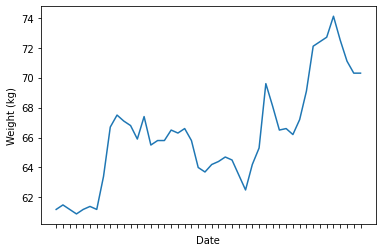

In [12]:
ax=sns.lineplot(x='Date', y='Weight (kg)', data=df_monthly_weight)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

#### 🔴 Workout

In [13]:
df_monthly_workout = df_monthly[df_monthly.Project=='Workout']

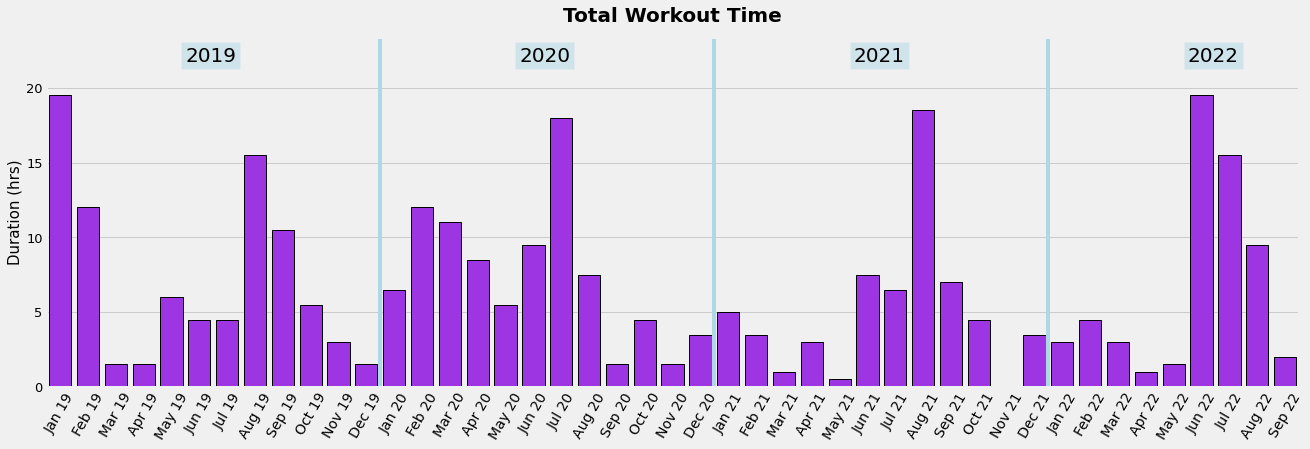

In [14]:
plot_monthly_single_barchart(df_monthly_workout, 'Total Workout Time')

### 🔵 Monthly: Total Productivity

In [15]:
# All
df_monthly_total = df_monthly.copy()
for project in df_monthly_total.Project.unique():
    df_monthly_total['Project'].replace(project, 'All', inplace=True)
df_monthly_total = df_monthly_total.groupby('Date', sort=False).sum()
df_monthly_total.reset_index(inplace=True)

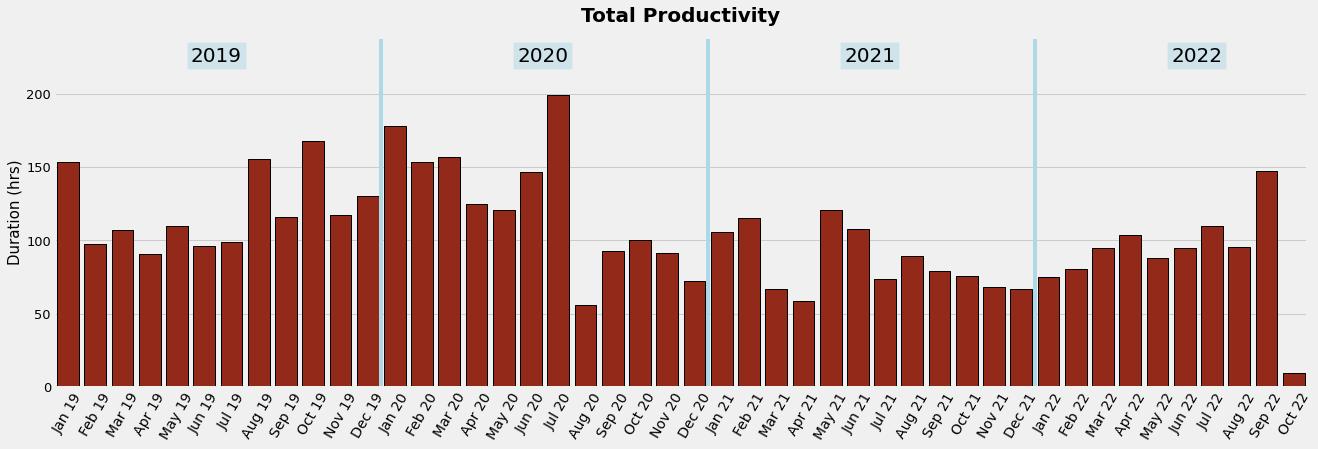

In [16]:
plot_monthly_single_barchart(df=df_monthly_total, title='Total Productivity', color='#A71A03')

### 🔵 Monthly: Academic vs Other Productivity
**Academic**
- Notes
- Data Science

**Other**
- To-Do
- Piano
- Workout

In [17]:
df_monthly_acad_other = df_monthly.copy()
df_monthly_acad_other['Project'].replace('Data Science', 'Academic', inplace=True)
df_monthly_acad_other['Project'].replace('Notes', 'Academic', inplace=True)
df_monthly_acad_other['Project'].replace('University', 'Academic', inplace=True)
df_monthly_acad_other['Project'].replace('To-Do', 'Other', inplace=True)
df_monthly_acad_other['Project'].replace('Piano', 'Other', inplace=True)
df_monthly_acad_other['Project'].replace('Workout', 'Other', inplace=True)
df_monthly_acad_other = df_monthly_acad_other.groupby(['Date', 'Project'], sort=False, as_index=False).sum()

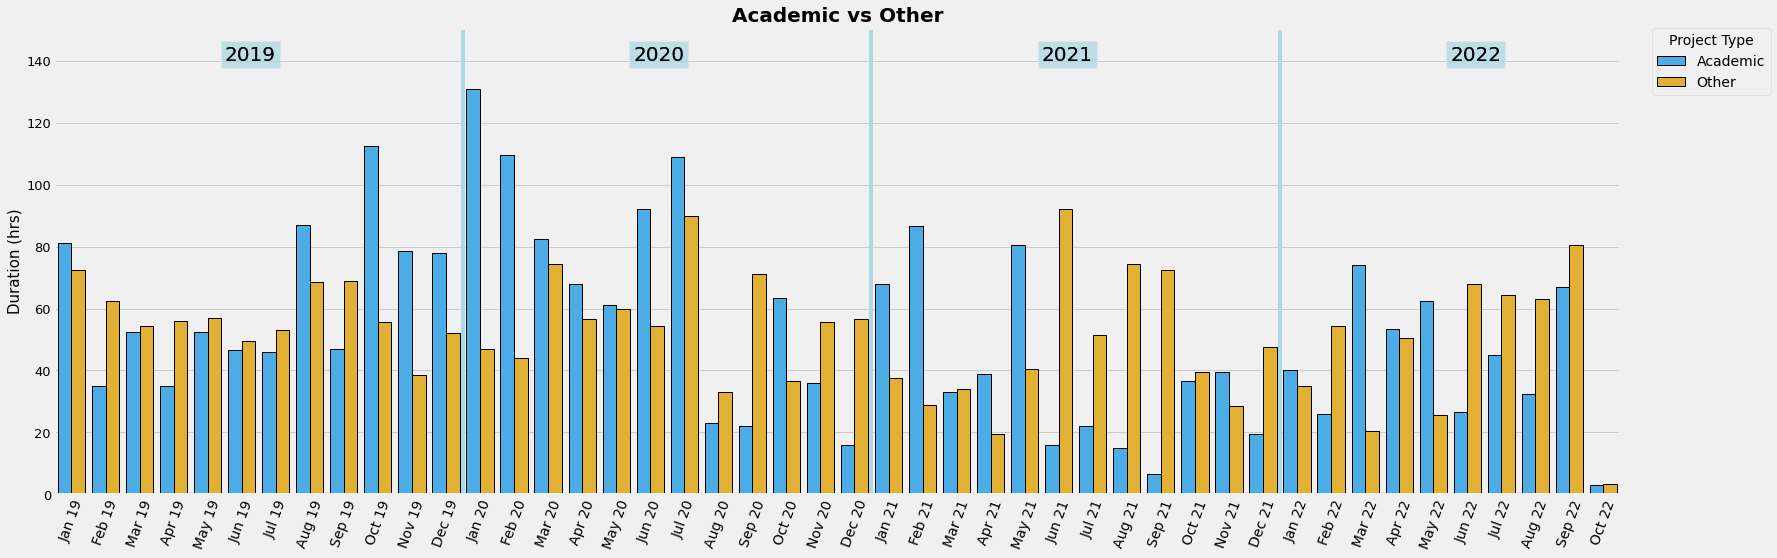

C:\Users\johng\AppData\Local\Temp\ipykernel_28904\1182228932.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


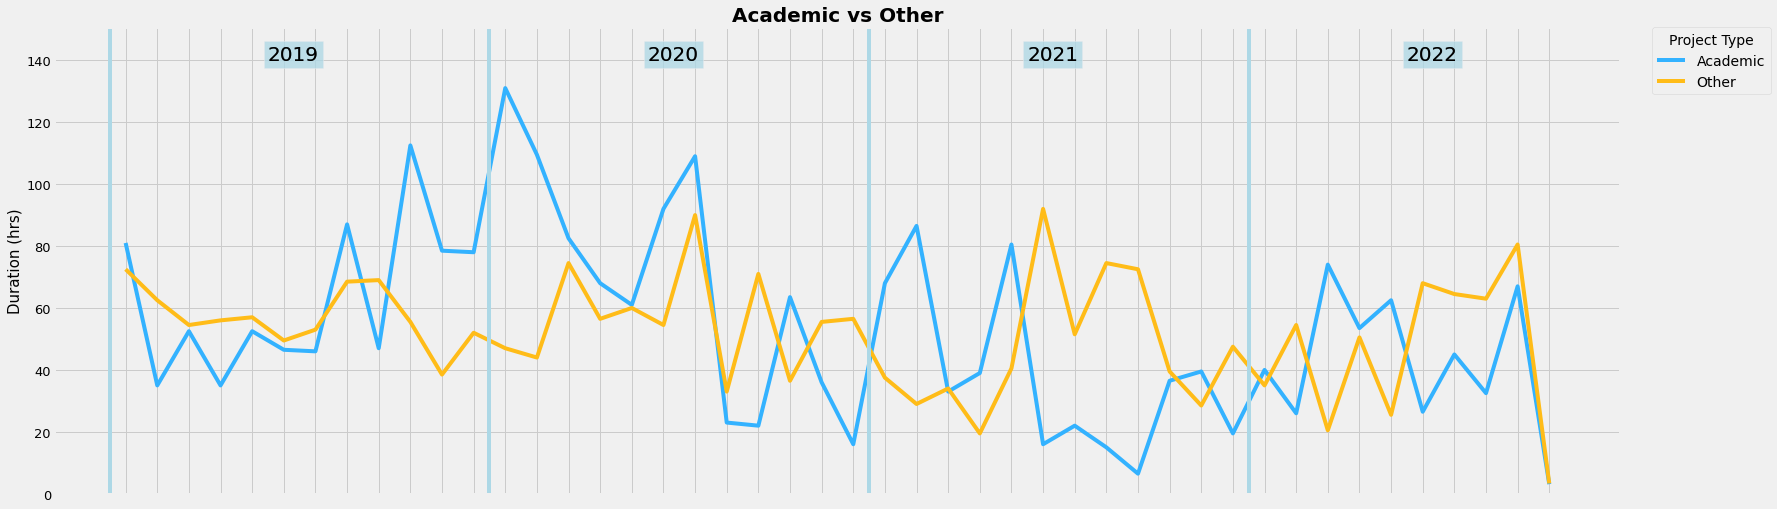

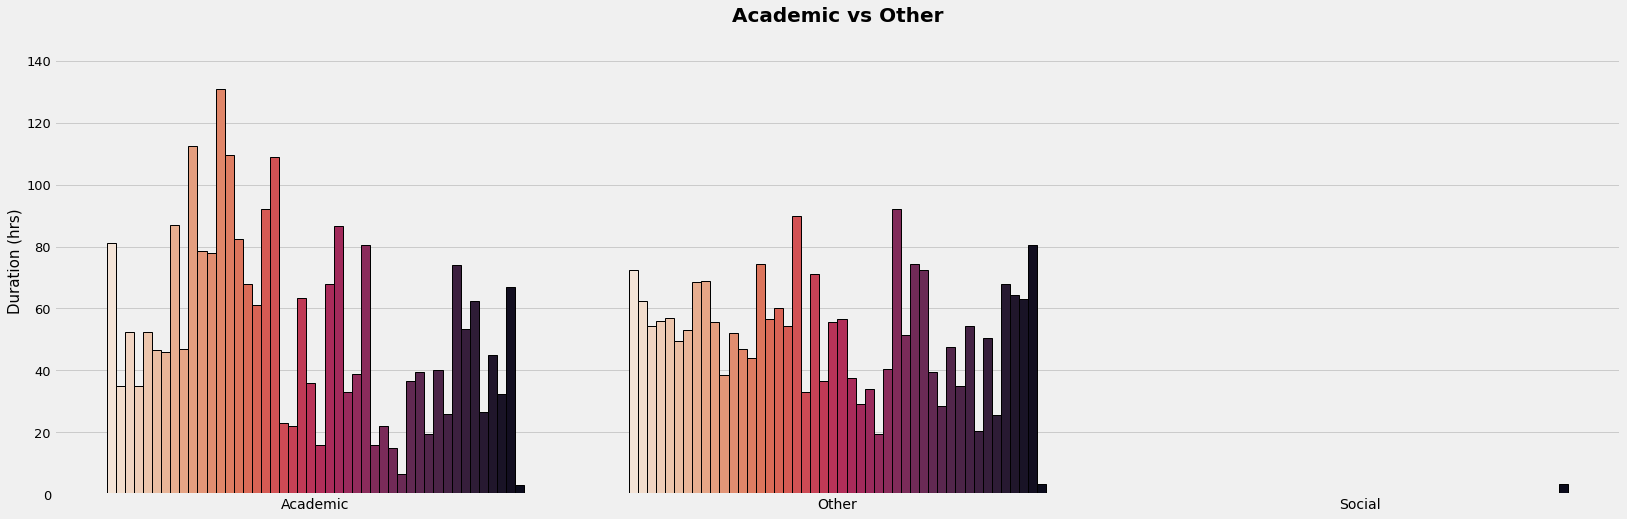

In [18]:
legendsize=10
title_size=20
title_pad = 15
bar_label_size=17
x_tick_size = 14
y_tick_size = 13
y_label_size=15
x_tick_rotation = 60
figsize=((25, 8))

title='Academic vs Other'


y_lim = df_monthly_acad_other['Duration (hrs)'].max() + df_monthly_acad_other['Duration (hrs)'].max() * 0.15

plt.style.use('fivethirtyeight') 
plt.figure(figsize=figsize)

# Set your custom color palette https://htmlcolorcodes.com/

colors = {'Other': "#FFBC18", 
          'Academic': "#33B2FF"}
hue_order = ['Academic', 'Other']


ax = sns.barplot(x='Date', y='Duration (hrs)', data=df_monthly_acad_other, hue='Project', ci=None, palette=colors, hue_order=hue_order, linewidth=1, edgecolor="k")
plt.xlabel('')
plt.ylabel('Duration (hrs)', fontsize=15)
plt.title(title, fontsize=title_size, fontweight='bold')
plt.ylim([0, y_lim])                                                    # Expand y axis range for visibility
ax.xaxis.set_tick_params(labelsize=x_tick_size)                         # Enlarge x ticks
ax.yaxis.set_tick_params(labelsize=y_tick_size)                         # Enlarge x ticks
#ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold') # Show values above bars
ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
plt.legend(title = 'Project Type', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)



line_locs = []
line_year = []
for count, value in enumerate(df_monthly_acad_other.Date):
    if value.startswith('Jan'):
        line_locs.append(count)
        line_year.append('20'+value[-2:])
#line_locs = [count for count, value in enumerate(df_monthly_acad_other.Date) if value.startswith('Jan')]
for loc, year in zip(line_locs, line_year):
    plt.axvline(x = loc//2-0.5, color = 'lightblue', label = 'Year', linewidth=4)
    ax.text(loc//2-0.5 + 5, y_lim - 0.07*y_lim, year, fontsize = 20, 
         bbox = dict(facecolor = 'lightblue', alpha = 0.5))


plt.show()






'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''







title='Academic vs Other'


y_lim = df_monthly_acad_other['Duration (hrs)'].max() + df_monthly_acad_other['Duration (hrs)'].max() * 0.15

plt.style.use('fivethirtyeight') 
plt.figure(figsize=figsize)

# Set your custom color palette https://htmlcolorcodes.com/

colors = {'Other': "#FFBC18", 
          'Academic': "#33B2FF"}
hue_order = ['Academic', 'Other']


ax = sns.lineplot(x='Date', y='Duration (hrs)', data=df_monthly_acad_other, hue='Project', ci=None, palette=colors, hue_order=hue_order)
plt.xlabel('')
plt.ylabel('Duration (hrs)', fontsize=15)
plt.title(title, fontsize=title_size, fontweight='bold')
plt.ylim([0, y_lim])                                                    # Expand y axis range for visibility
ax.xaxis.set_tick_params(labelsize=x_tick_size)                         # Enlarge x ticks
ax.yaxis.set_tick_params(labelsize=y_tick_size)                         # Enlarge x ticks
#ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold') # Show values above bars
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.legend(title = 'Project Type', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


line_locs = []
line_year = []
for count, value in enumerate(df_monthly_acad_other.Date):
    if value.startswith('Jan'):
        line_locs.append(count)
        line_year.append('20'+value[-2:])
#line_locs = [count for count, value in enumerate(df_monthly_acad_other.Date) if value.startswith('Jan')]
for loc, year in zip(line_locs, line_year):
    plt.axvline(x = loc//2-0.5, color = 'lightblue', label = 'Year', linewidth=4)
    ax.text(loc//2-0.5 + 5, y_lim - 0.07*y_lim, year, fontsize = 20, 
         bbox = dict(facecolor = 'lightblue', alpha = 0.5))




plt.show()








'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''









title='Academic vs Other'
sns.set_palette(sns.color_palette("rocket_r"))
#sns.set_palette(sns.dark_palette("#69d", reverse=True, as_cmap=True))

y_lim = df_monthly_acad_other['Duration (hrs)'].max() + df_monthly_acad_other['Duration (hrs)'].max() * 0.15

plt.style.use('fivethirtyeight') 
plt.figure(figsize=figsize)

# Set your custom color palette https://htmlcolorcodes.com/

colors = {'Other': "#FFBC18", 'Academic': "#33B2FF"}


ax = sns.barplot(x='Project', y='Duration (hrs)', data=df_monthly_acad_other, hue='Date', ci=None, palette = 'rocket_r', linewidth=1, edgecolor="k")
plt.xlabel('')
plt.ylabel('Duration (hrs)', fontsize=15)
plt.title(title, fontsize=title_size, fontweight='bold')
plt.ylim([0, y_lim])                                                    # Expand y axis range for visibility
ax.xaxis.set_tick_params(labelsize=x_tick_size)                         # Enlarge x ticks
ax.yaxis.set_tick_params(labelsize=y_tick_size)                         # Enlarge x ticks
#ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold') # Show values above bars
plt.legend([],[], frameon=False)

plt.show()


In [19]:
# for style in plt.style.available:
#     print(style)
#     plt.figure(figsize=(20,10))
#     plt.style.use(style) 

#     ax = sns.barplot(x='Project', y='Duration (hrs)', data=df_monthly_acad_other, hue='Date', ci=None, palette = 'rocket_r')
#     plt.legend([],[], frameon=False)
#     plt.show()

### 🔵 Monthly: Individual Projects

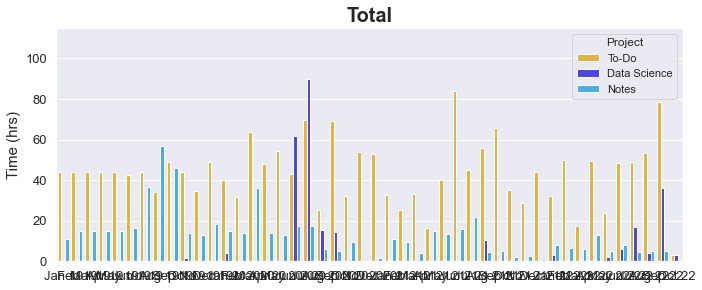

In [20]:
figsize=(10,4)
legendsize=10
title_size=20
bar_label_size=17
x_tick_size = 13
y_tick_size = 13

sns.set_theme(style="darkgrid")
plt.figure(figsize=figsize)

# Set your custom color palette https://htmlcolorcodes.com/
unique_projects = df_monthly.Project.unique().shape[0]

colors = {'To-Do': "#FABF2D", 
          'Notes': "#33B2FF", 
          'Data Science': "#332DFA", 
          'Piano': '0FB528', 
          'Workout': 'C01E05'}

hue_order = ['To-Do', 'Data Science', 'Notes']


ax = sns.barplot(x='Date', y='Duration (hrs)', data=df_monthly, hue='Project', ci=None, palette=colors, hue_order=hue_order)
plt.xlabel('')
plt.ylabel('Time (hrs)', fontsize=15)
plt.title('Total', fontsize=title_size, fontweight='bold')
#ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold', label_type='center') # Show values above bars
plt.ylim([0, df_monthly['Duration (hrs)'].max() + 3])     # Expand y axis range for visibility
ax.xaxis.set_tick_params(labelsize=x_tick_size)                         # Enlarge x ticks
ax.yaxis.set_tick_params(labelsize=y_tick_size)                         # Enlarge x ticks

plt.show()

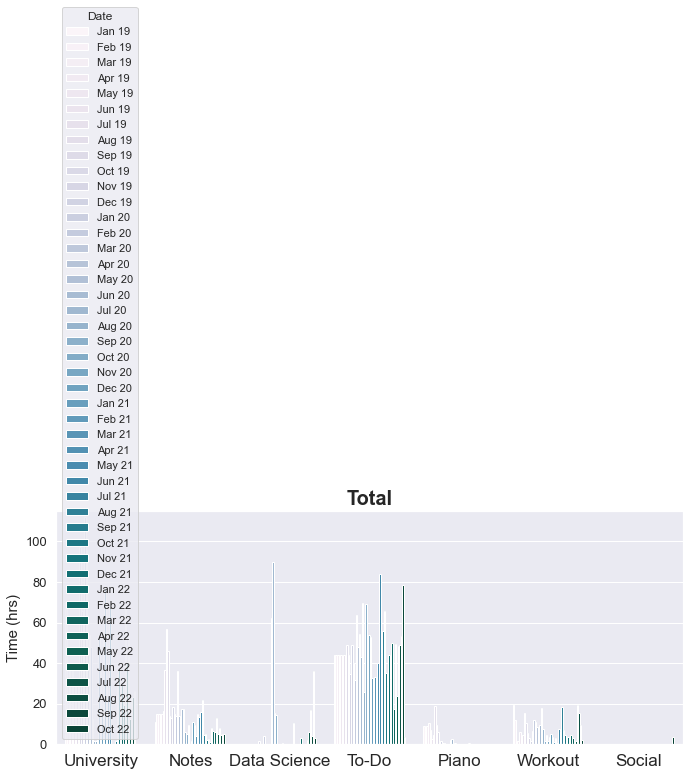

In [21]:
## figsize=(12,4)
legendsize=10
title_size=20
bar_label_size=17

sns.set_theme(style="darkgrid")
plt.figure(figsize=figsize)

ax = sns.barplot(x='Project', y='Duration (hrs)', data=df_monthly, hue='Date', ci=None, palette='PuBuGn')
plt.xlabel('')
plt.ylabel('Time (hrs)', fontsize=15)
plt.title('Total', fontsize=title_size, fontweight='bold')
#ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold', label_type='center') # Show values above bars
plt.ylim([0, df_monthly['Duration (hrs)'].max() + 3])     # Expand y axis range for visibility
ax.xaxis.set_tick_params(labelsize=17)                         # Enlarge x ticks
ax.yaxis.set_tick_params(labelsize=13)                         # Enlarge x ticks

plt.show()

### 🔵 Monthly: Project Breakdown (Data Science, TODO, etc.)

In [22]:
df.Project.unique()

array(['To-Do', 'Weight', 'Data Science', 'Social'], dtype=object)

In [23]:
def preprocess_project(df, project):
    
    df_monthly_project = df.copy()
    df_monthly_project = df_monthly_project.rename(columns={'Start': 'Date'})
    df_monthly_project['Date'] = df_monthly_project['Date'].dt.strftime('%b %y')
    df_monthly_project = df_monthly_project[df_monthly_project.Project == project]
    df_monthly_project = df_monthly_project.drop(['Project', 'Task', 'Start date', 'Start time', 'End date', 'End time', 'Tags', 'End'], axis=1)
    df_monthly_project = df_monthly_project.rename({'Description': 'Project'}, axis=1)
    df_monthly_project = df_monthly_project.groupby(['Date', 'Project'], sort=False, as_index=False).sum()

    return df_monthly_project

df_monthly_todo = preprocess_project(df, 'To-Do')
df_monthly_data_science = preprocess_project(df, 'Data Science')
#df_monthly_notes = preprocess_project(df, 'Notes')

In [24]:
df_monthly_todo

,Date,Project,Duration (hrs)
0,Oct 22,*,0.936389
1,Oct 22,Jobs,2.406944


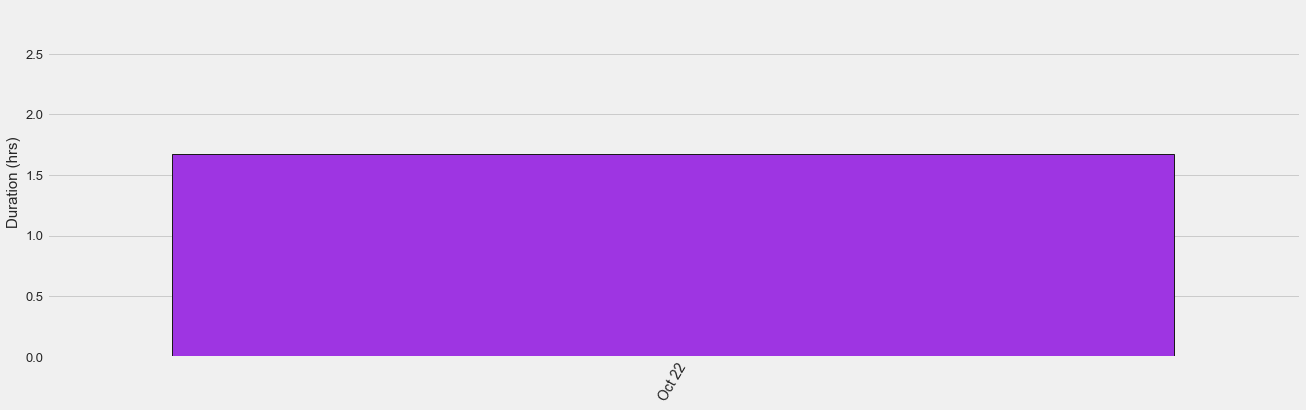

In [25]:
plot_monthly_single_barchart(df_monthly_todo)

### 🔵 TODO: Subplot these

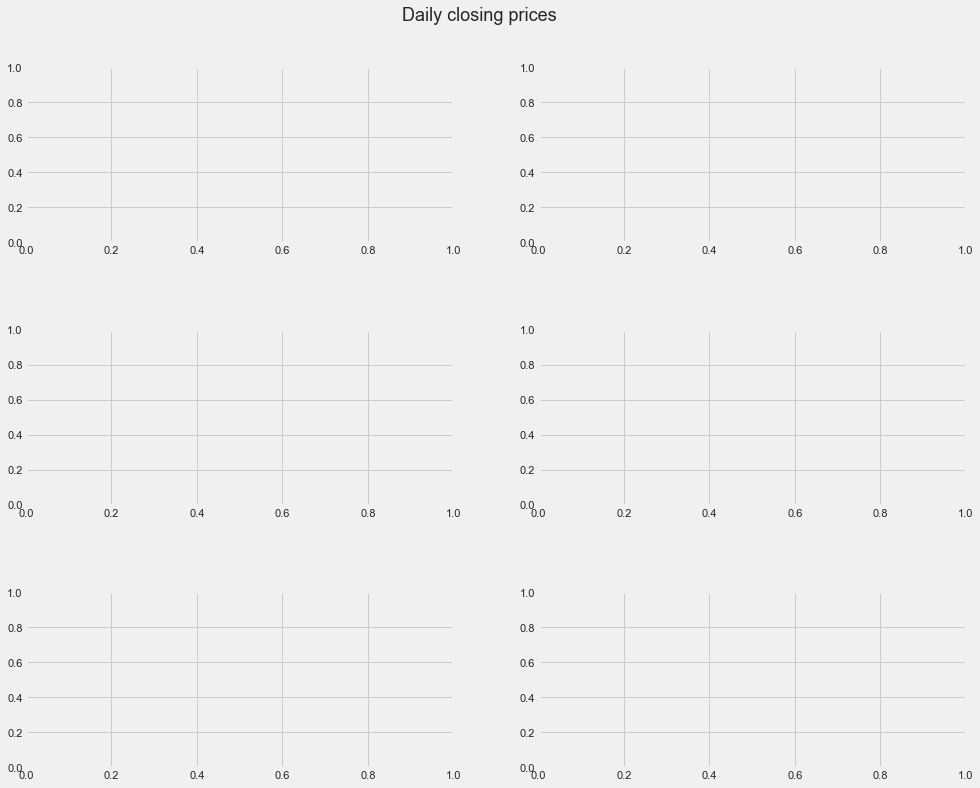

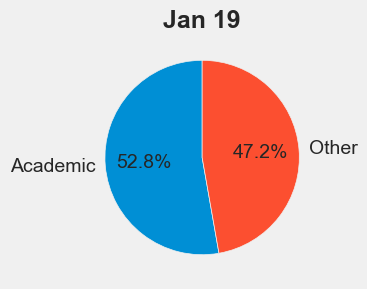

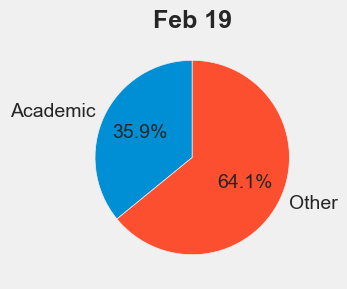

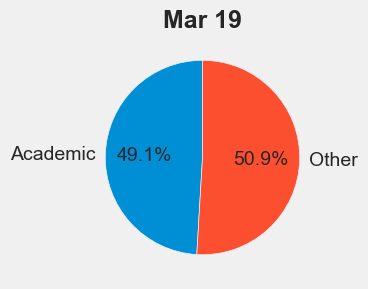

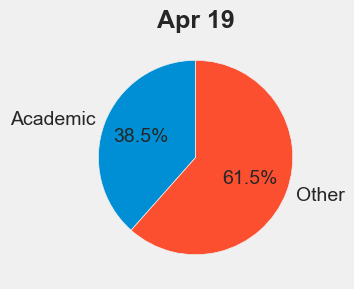

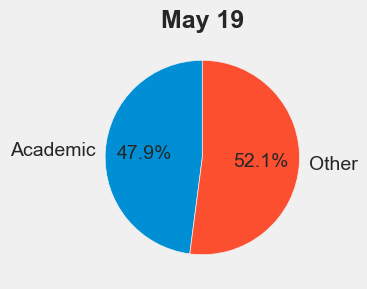

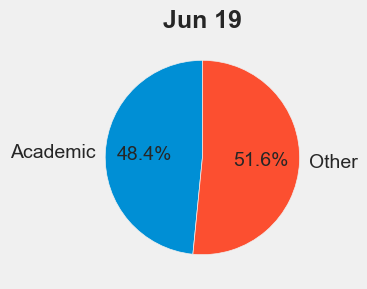

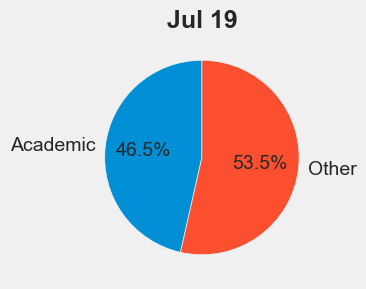

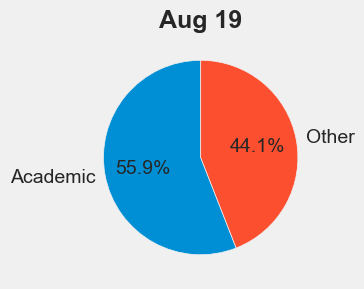

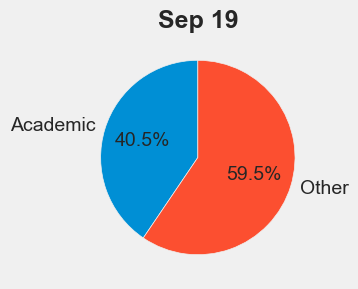

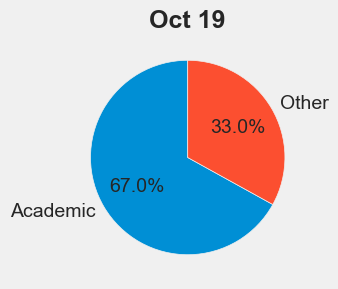

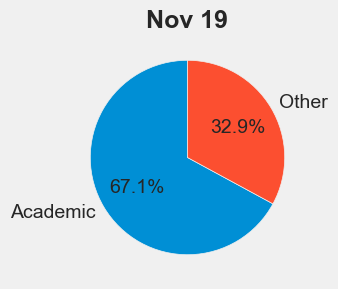

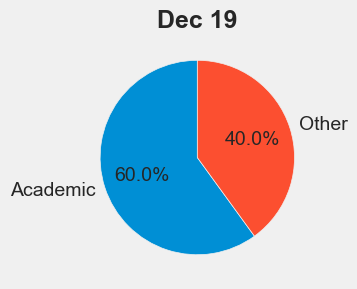

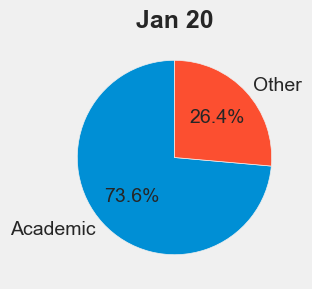

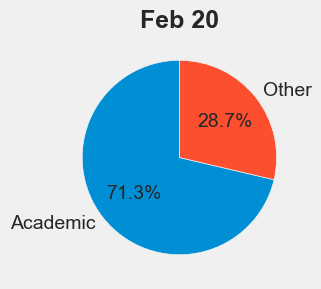

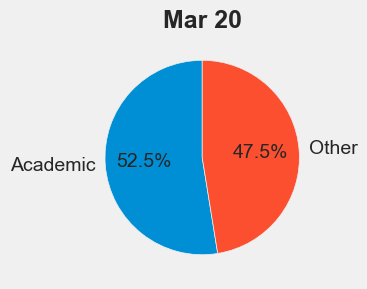

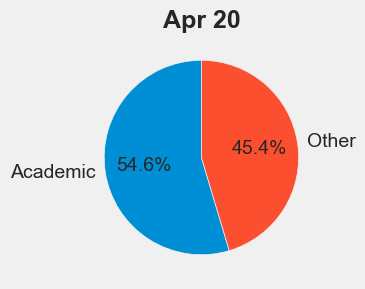

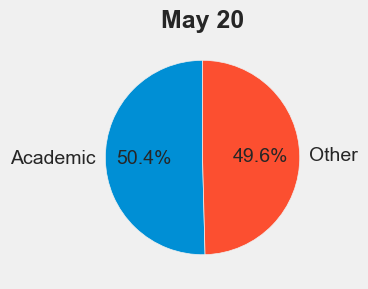

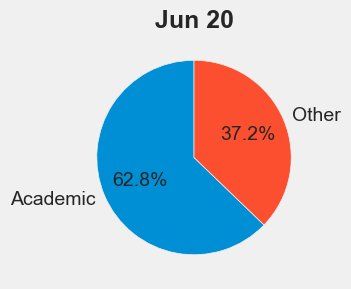

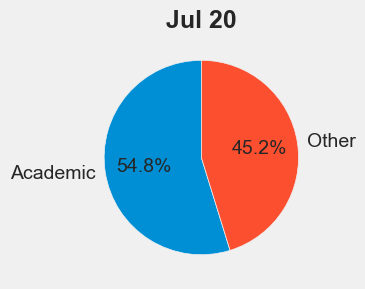

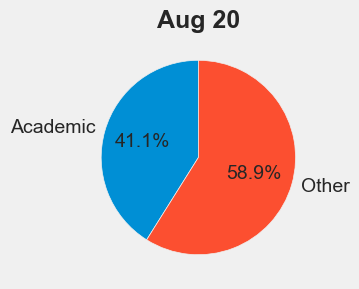

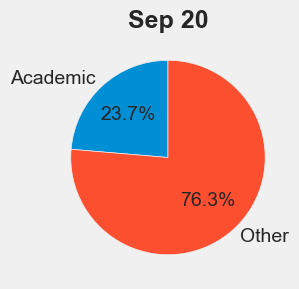

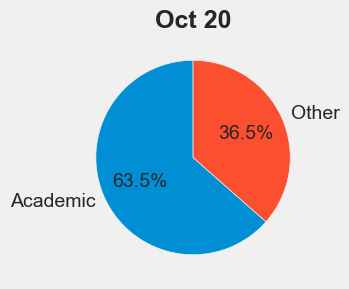

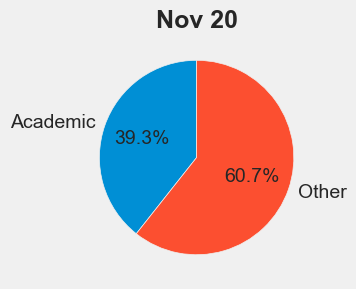

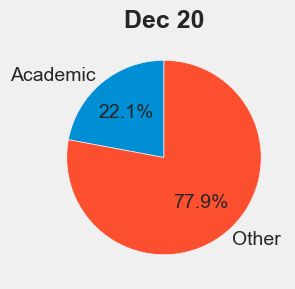

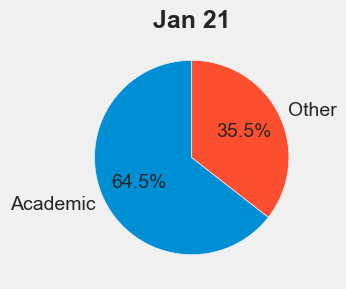

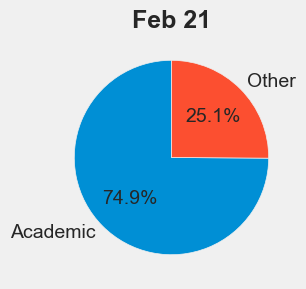

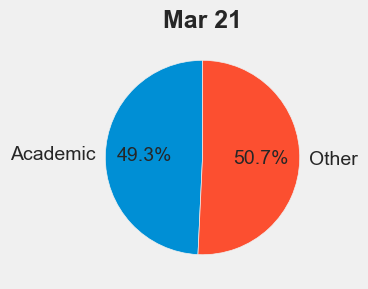

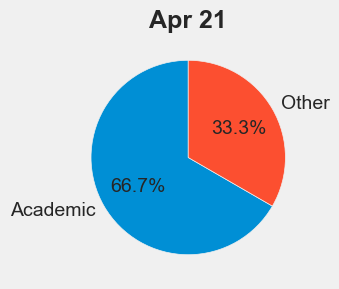

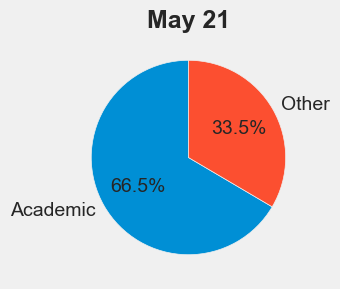

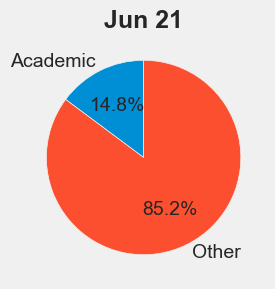

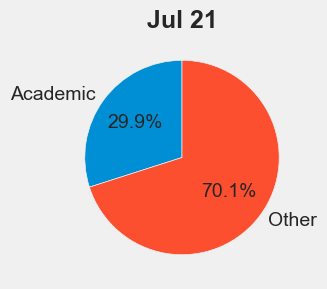

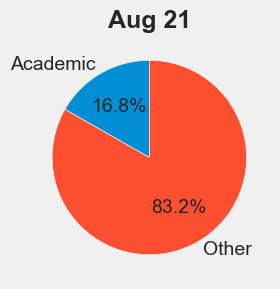

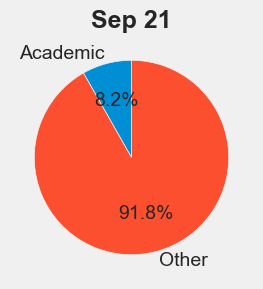

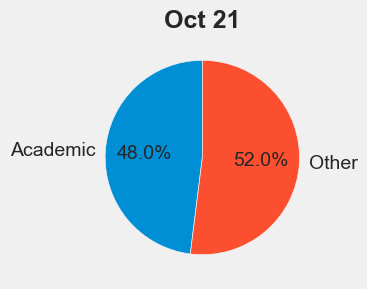

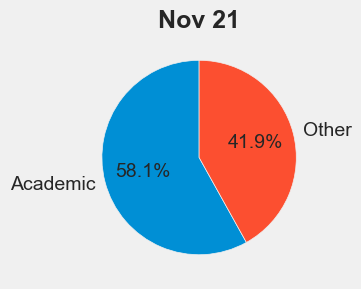

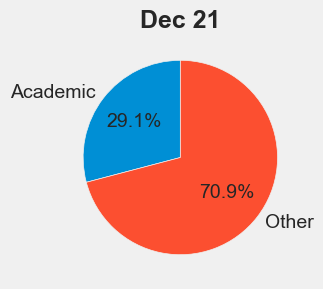

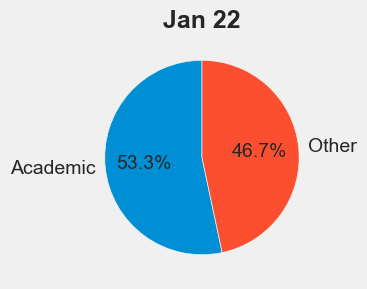

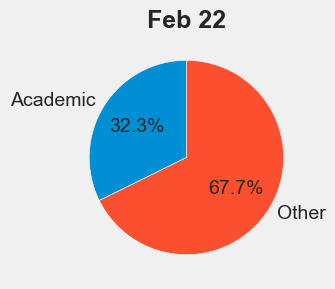

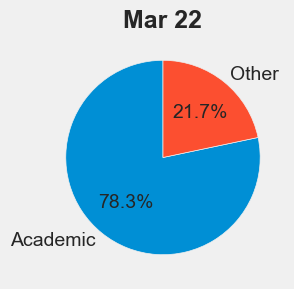

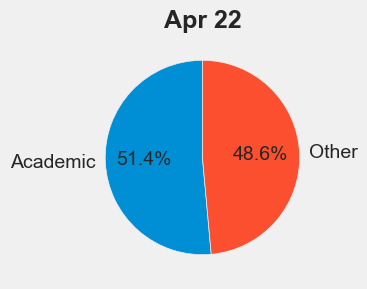

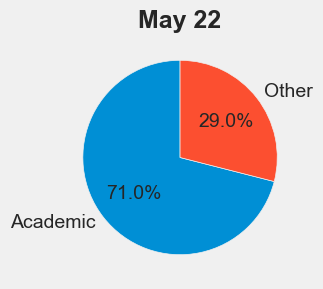

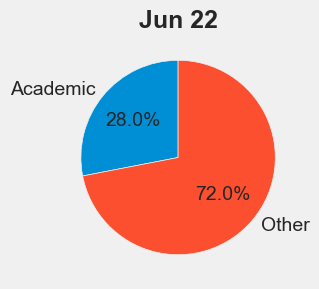

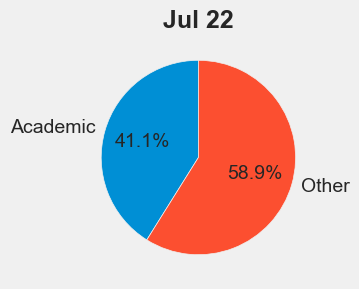

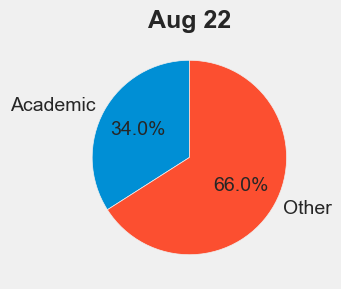

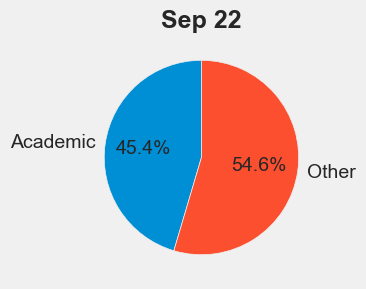

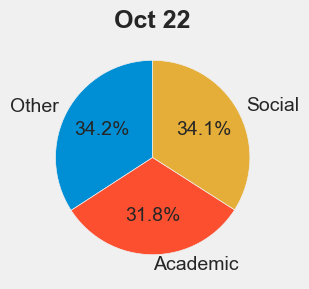

In [26]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Daily closing prices", fontsize=18, y=0.95)

data_pre = df_monthly_acad_other.groupby(['Date', 'Project'], sort=False, as_index=False).sum()
months = data_pre['Date'].unique()
for date in months:
    data = np.array(data_pre[data_pre.Date == date]['Duration (hrs)'])
    labels = np.array(data_pre[data_pre.Date == date].Project)
    fig = plt.figure(figsize=(4, 3), dpi=100)
    plt.pie(x=data, labels=labels, startangle=90, autopct='%1.1f%%', textprops={'fontsize': 14})
    plt.title(date, fontweight='bold', fontsize=18)
    plt.show()

### 🔵 Annual Breakdown